# Deep Learning Course Project - Gesture Recognition

## Problem Statement

Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:

| Gesture | Corresponding Action |
| --- | --- |
| Thumbs Up | Increase the volume. |
| Thumbs Down | Decrease the volume. |
| Left Swipe | 'Jump' backwards 10 seconds. |
| Right Swipe | 'Jump' forward 10 seconds. |
| Stop | Pause the movie. |

Each video is a sequence of 30 frames (or images).

## Goal

We need to do following things, in order to justify the problem statement given for gesture recognition:

1. **Generator**:  The generator should be able to take a batch of videos as input without any error. Steps like cropping, resizing and normalization should be performed successfully.

2. **Model**: Develop a model that is able to train without any errors which will be judged on the total number of parameters (as the inference(prediction) time should be less) and the accuracy achieved. Also, as per the instruction given by Upgrad, start training on a small amount of data and then proceed further.

3. **Write up**: This should contain the detailed procedure followed in choosing the final model. The write up should start with the reason for choosing the base model, then highlight the reasons and metrics taken into consideration to modify and experiment to arrive at the final model.

----

In [ ]:
## Checking the GPU configuration

!nvidia-smi

Tue Aug  8 14:32:44 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## *`Importing Data and necessary libraries`*

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp '/content/drive/MyDrive/Project_data.zip' '/content'
!unzip '/content/Project_data.zip' -d '/content/DLP'

Streaming output truncated to the last 5000 lines.
 extracting: /content/DLP/Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00050.png  
 extracting: /content/DLP/Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00052.png  
 extracting: /content/DLP/Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00054.png  
 extracting: /content/DLP/Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00056.png  
 extracting: /content/DLP/Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00058.png  
 extracting: /content/DLP/Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00060.png  
 extracting: /content/DLP/Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00062.png  
   creating: /content/DLP/Project_data/train/WIN_20180926_17_35_12_Pro_Thumbs_Down_new/
 extracting: /content/DLP/Project_d

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import backend as K
import random as rn
import os
from imageio import imread
import cv2
import matplotlib.pyplot as plt
import datetime
import time

from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation,GlobalAveragePooling2D, ConvLSTM2D
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.layers import LSTM
from keras import optimizers
from keras.layers import Dropout
from keras.applications import mobilenet
from keras import backend as K

In [ ]:
#We set the random seed so that the results don't vary drastically.
np.random.seed(30)
rn.seed(30)
tf.random.set_seed(30)

In [ ]:
# Deriving data folder paths
data_folder = '/content/DLP/Project_data'

train_path = data_folder + '/train'
val_path = data_folder + '/val'

total_frames = 30
num_gestures = 5

trial_count = 1

We need to set the `batch_size` later on. Note that we should set the batch size in such a way that we are able to use the GPU in full capacity. we will then keep increasing the batch size until the machine throws an error.

In [ ]:
train_doc = np.random.permutation(open(data_folder + '/train.csv').readlines())
val_doc = np.random.permutation(open(data_folder + '/val.csv').readlines())

## *`Generator`*
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [ ]:
# function to plot the training/validation accuracies/losses.

def plot_training_validation_graph(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])
    plt.show()

In [ ]:
def get_batch_data(source_path, folder_list, batch_size, num_gesture_frames, image_size, num_channels, batch, img_idx, t) :
  batch_data = np.zeros((batch_size,num_gesture_frames,image_size,image_size,num_channels)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
  batch_labels = np.zeros((batch_size,num_gestures)) # batch_labels is the one hot representation of the output
  for folder in range(batch_size): # iterate over the batch_size
      gesture_info = t[folder + batch * batch_size].strip().split(';')
      imgs = os.listdir(source_path+'/'+ gesture_info[0]) # read all the images in the folder
      for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
          if num_channels == 3 :
            image = imread(source_path + '/' + gesture_info[0] +'/'+imgs[item]).astype(np.float32)

            #crop the images and resize them. Note that the images are of 2 different shape
            #and the conv3D will throw error if the inputs in a batch have different shapes
            image = cv2.resize(image, (image_size, image_size))

            batch_data[folder,idx,:,:,0] = (image[:,:,0]) / 255.0 #normalise and feed in the image
            batch_data[folder,idx,:,:,1] = (image[:,:,1]) / 255.0 #normalise and feed in the image
            batch_data[folder,idx,:,:,2] = (image[:,:,2]) / 255.0  #normalise and feed in the image
          else :
            image = cv2.imread(source_path + '/' + gesture_info[0] +'/'+imgs[item], cv2.IMREAD_GRAYSCALE)
            image = cv2.resize(image, (image_size, image_size))
            batch_data[folder,idx,:,:,0] = image / 255.0

      batch_labels[folder, int(gesture_info[2])] = 1
  return batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

In [ ]:
def generator(source_path, folder_list, batch_size, num_gesture_frames, image_size, num_channels):
    img_idx =  np.round(np.linspace(0, total_frames - 1, num_gesture_frames)).astype(int) #create a list of image numbers you want to use for a particular video

    while True:
        t = np.random.permutation(folder_list)
        num_batches =  len(t) // batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            yield get_batch_data(source_path, folder_list, batch_size, num_gesture_frames, image_size, num_channels, batch, img_idx, t)

        # write the code for the remaining data points which are left after full batches

        rem_batch_size = len(t) % batch_size
        yield get_batch_data(source_path, folder_list, rem_batch_size, num_gesture_frames, image_size, num_channels, num_batches, img_idx, t)

## *`Model Function`*

Here we are building a generic functio, which can be called after creating the model and then we will compile and plot training validation graph for the same.

In [ ]:
def build_model(model_text, model, batch_size, num_epochs, num_gesture_frames, image_size, num_channels, learning_rate=0.001) :
  optimiser = tf.keras.optimizers.Adam(learning_rate=learning_rate)
  model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

  train_generator = generator(train_path, train_doc, batch_size, num_gesture_frames, image_size, num_channels)
  val_generator = generator(val_path, val_doc, batch_size, num_gesture_frames, image_size, num_channels)

  num_train_sequences = len(train_doc)
  num_val_sequences = len(val_doc)

  if (num_train_sequences % batch_size) == 0:
      steps_per_epoch = int(num_train_sequences/batch_size)
  else:
      steps_per_epoch = (num_train_sequences//batch_size) + 1

  if (num_val_sequences%batch_size) == 0:
      validation_steps = int(num_val_sequences/batch_size)
  else:
      validation_steps = (num_val_sequences//batch_size) + 1

  model_name = model_text + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'

  if not os.path.exists(model_name):
      os.mkdir(model_name)

  filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

  checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')
  LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=5)
  callbacks_list = [checkpoint, LR]

  history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

  plot_training_validation_graph(history)
  return history

## *`Model Memory Function`*

Let's also analyze the memory usage and the count of trainable parameters.

In [ ]:
def get_model_memory_usage(batch_size, model):
    shapes_mem_count = 0
    internal_model_mem_count = 0
    for l in model.layers:
        layer_type = l.__class__.__name__
        if layer_type == 'Model':
            internal_model_mem_count += get_model_memory_usage(batch_size, l)
        single_layer_mem = 1
        out_shape = l.output_shape
        if type(out_shape) is list:
            out_shape = out_shape[0]
        for s in out_shape:
            if s is None:
                continue
            single_layer_mem *= s
        shapes_mem_count += single_layer_mem

    trainable_count = np.sum([K.count_params(p) for p in model.trainable_weights])
    non_trainable_count = np.sum([K.count_params(p) for p in model.non_trainable_weights])

    number_size = 4.0
    if K.floatx() == 'float16':
        number_size = 2.0
    if K.floatx() == 'float64':
        number_size = 8.0

    total_memory = number_size * (batch_size * shapes_mem_count + trainable_count + non_trainable_count)
    mbs = np.round(total_memory / (1024.0 ** 2), 3) + internal_model_mem_count
    return mbs

## *`Model`*
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

**Let's create a generic function for CNN_3D to experiment with different model, given with different input paramters**

In [ ]:
def try_cnn3d_only(batch_size, num_epochs, num_gesture_frames, image_size, num_channels, batch_normalize, learning_rate, dropout, dense_neurons) :
  model = Sequential()
  model.add(Conv3D(16, (3, 3, 3), padding='same', input_shape=(num_gesture_frames,image_size,image_size,num_channels)))
  model.add(Activation('relu'))
  model.add(MaxPooling3D(pool_size=(2, 2, 2)))

  model.add(Conv3D(32, (2, 2, 2), padding='same'))
  model.add(Activation('relu'))
  model.add(MaxPooling3D(pool_size=(2, 2, 2)))

  model.add(Conv3D(64, (2, 2, 2), padding='same'))
  model.add(Activation('relu'))
  model.add(MaxPooling3D(pool_size=(2, 2, 2)))

  model.add(Conv3D(128, (2, 2, 2), padding='same'))
  model.add(Activation('relu'))
  model.add(MaxPooling3D(pool_size=(2, 2, 2)))

  model.add(Flatten())
  model.add(Dense(dense_neurons,activation='relu'))
  model.add(Dropout(dropout))

  model.add(Dense(dense_neurons // 2,activation='relu'))
  if batch_normalize:
    model.add(BatchNormalization())
  model.add(Dropout(dropout))

  model.add(Dense(num_gestures,activation='softmax'))

  print('Total params: {:,}'.format(model.count_params()))

  return build_model("cnn3d_only", model, batch_size, num_epochs, num_gesture_frames, image_size, num_channels, learning_rate),model

***Let's start with out quest to experiment with different model and their performances***

### *`MODEL-CNN3D 1`*

Total params: 357,541
Epoch 1/25
23/23 [==============================] - ETA: 0s - loss: 1.5982 - categorical_accuracy: 0.2036
Epoch 1: val_loss improved from inf to 1.50627, saving model to cnn3d_only_2023-08-0811_32_03.973054/model-00001-1.59816-0.20362-1.50627-0.24000.h5
23/23 [==============================] - 61s 3s/step - loss: 1.5982 - categorical_accuracy: 0.2036 - val_loss: 1.5063 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 2/25
23/23 [==============================] - ETA: 0s - loss: 1.4904 - categorical_accuracy: 0.3243
Epoch 2: val_loss improved from 1.50627 to 1.32310, saving model to cnn3d_only_2023-08-0811_32_03.973054/model-00002-1.49036-0.32428-1.32310-0.41000.h5
23/23 [==============================] - 54s 2s/step - loss: 1.4904 - categorical_accuracy: 0.3243 - val_loss: 1.3231 - val_categorical_accuracy: 0.4100 - lr: 0.0010
Epoch 3/25
22/23 [===========================>..] - ETA: 1s - loss: 1.3893 - categorical_accuracy: 0.4076
Epoch 3: val_loss did not im

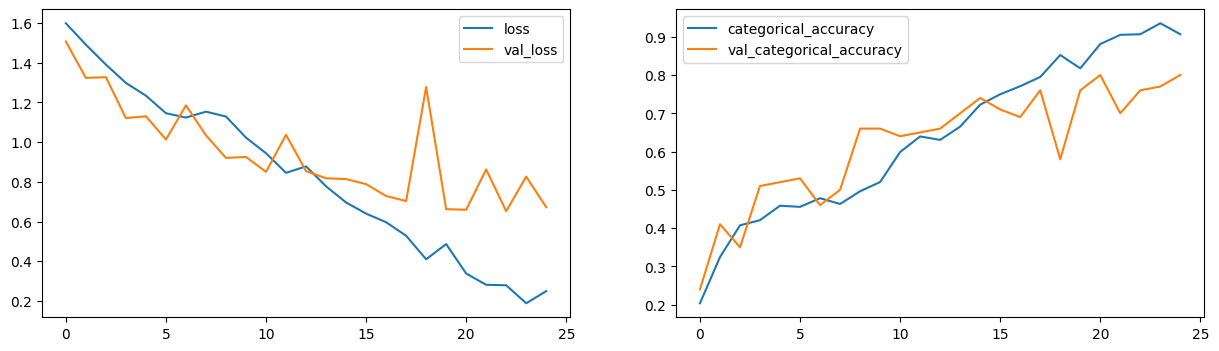

Execution time (secs): 1206.646341085434 Memory usage(MB) 632.346
Best stats:
        loss  categorical_accuracy  val_loss  val_categorical_accuracy     lr
22  0.279128              0.906486  0.651742                      0.76  0.001


In [ ]:
st = time.time()
batch_size = 30
hist,model = try_cnn3d_only(batch_size=30, num_epochs=25, num_gesture_frames=30,
                                   image_size= 64, num_channels=1, batch_normalize= False,
                                   learning_rate= 0.001, dropout= 0.25, dense_neurons= 128)
df_train = pd.DataFrame(hist.history)
df_best = df_train[df_train['val_loss'] == df_train['val_loss'].min()]
et = time.time()
elapsed_time = et - st
mbs = get_model_memory_usage(30, model)
print("Execution time (secs):", elapsed_time, "Memory usage(MB)", mbs)
print("Best stats:")
print(df_best)


### *`MODEL-CNN3D 2`*

Total params: 2,218,501


<ipython-input-9-9dc86df5bb8a>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(source_path + '/' + gesture_info[0] +'/'+imgs[item]).astype(np.float32)


Epoch 1/25
17/17 [==============================] - ETA: 0s - loss: 1.5814 - categorical_accuracy: 0.2187
Epoch 1: val_loss improved from inf to 1.44908, saving model to cnn3d_only_2023-08-0811_53_05.200916/model-00001-1.58139-0.21870-1.44908-0.33000.h5
17/17 [==============================] - 87s 5s/step - loss: 1.5814 - categorical_accuracy: 0.2187 - val_loss: 1.4491 - val_categorical_accuracy: 0.3300 - lr: 0.0010
Epoch 2/25
17/17 [==============================] - ETA: 0s - loss: 1.3828 - categorical_accuracy: 0.3816
Epoch 2: val_loss improved from 1.44908 to 1.25533, saving model to cnn3d_only_2023-08-0811_53_05.200916/model-00002-1.38283-0.38160-1.25533-0.41000.h5
17/17 [==============================] - 82s 5s/step - loss: 1.3828 - categorical_accuracy: 0.3816 - val_loss: 1.2553 - val_categorical_accuracy: 0.4100 - lr: 0.0010
Epoch 3/25
17/17 [==============================] - ETA: 0s - loss: 1.2771 - categorical_accuracy: 0.4238
Epoch 3: val_loss improved from 1.25533 to 1.18348

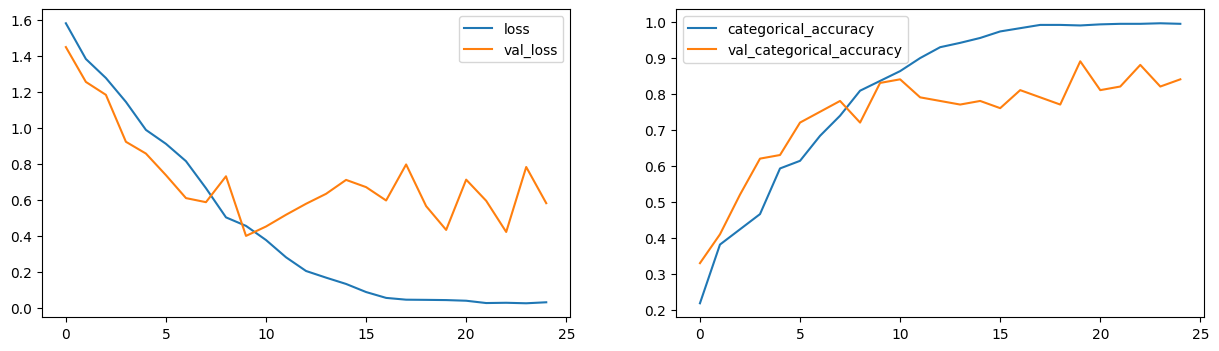

Execution time (secs): 1960.703153848648 Memory usage(MB) 3373.581
Best stats:
       loss  categorical_accuracy  val_loss  val_categorical_accuracy     lr
9  0.454797              0.835596  0.399113                      0.83  0.001


In [ ]:
st = time.time()
hist,model = try_cnn3d_only(batch_size= 40, num_epochs= 25, num_gesture_frames= 30,
                                   image_size= 128, num_channels= 3, batch_normalize= False,
                                   learning_rate= 0.001, dropout= 0.25, dense_neurons= 256)
df_train = pd.DataFrame(hist.history)
df_best = df_train[df_train['val_loss'] == df_train['val_loss'].min()]
et = time.time()
elapsed_time = et - st
mbs = get_model_memory_usage(40, model)
print("Execution time (secs):", elapsed_time, "Memory usage(MB)", mbs)
print("Best stats:")
print(df_best)

### *`MODEL-CNN3D 3`*

Total params: 2,218,501


<ipython-input-9-9dc86df5bb8a>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(source_path + '/' + gesture_info[0] +'/'+imgs[item]).astype(np.float32)


Epoch 1/30
17/17 [==============================] - ETA: 0s - loss: 1.6055 - categorical_accuracy: 0.2504
Epoch 1: val_loss improved from inf to 1.56638, saving model to cnn3d_only_2023-08-0812_30_21.706834/model-00001-1.60552-0.25038-1.56638-0.21000.h5
17/17 [==============================] - 48s 3s/step - loss: 1.6055 - categorical_accuracy: 0.2504 - val_loss: 1.5664 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/30
17/17 [==============================] - ETA: 0s - loss: 1.5536 - categorical_accuracy: 0.3017
Epoch 2: val_loss improved from 1.56638 to 1.53296, saving model to cnn3d_only_2023-08-0812_30_21.706834/model-00002-1.55362-0.30166-1.53296-0.27000.h5
17/17 [==============================] - 42s 3s/step - loss: 1.5536 - categorical_accuracy: 0.3017 - val_loss: 1.5330 - val_categorical_accuracy: 0.2700 - lr: 0.0010
Epoch 3/30
17/17 [==============================] - ETA: 0s - loss: 1.3562 - categorical_accuracy: 0.4329
Epoch 3: val_loss improved from 1.53296 to 1.27181

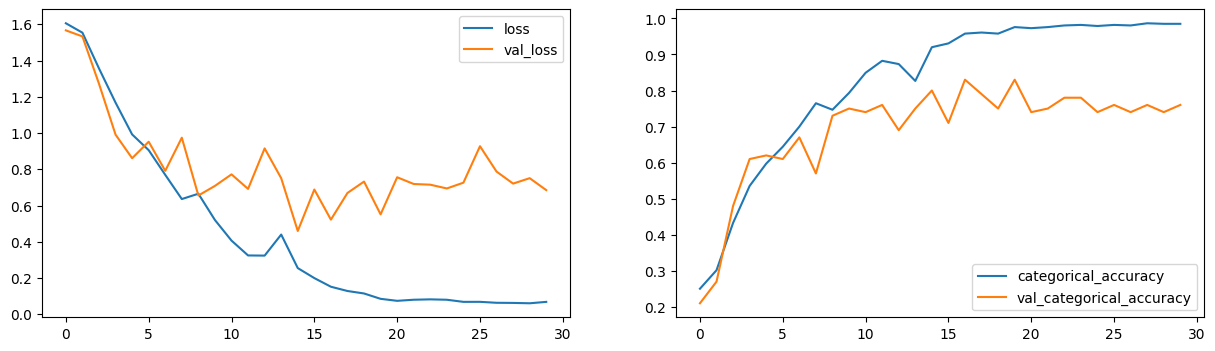

Execution time (secs): 1264.8331170082092 Memory usage(MB) 2168.698
Best stats:
        loss  categorical_accuracy  val_loss  val_categorical_accuracy      lr
14  0.254739               0.92006  0.459508                       0.8  0.0002


In [ ]:
st = time.time()
hist,model = try_cnn3d_only(batch_size= 40, num_epochs= 30, num_gesture_frames= 16,
                                   image_size= 140, num_channels= 3, batch_normalize= False,
                                   learning_rate= 0.001, dropout=0.25, dense_neurons=256)
df_train = pd.DataFrame(hist.history)
df_best = df_train[df_train['val_loss'] == df_train['val_loss'].min()]
et = time.time()
elapsed_time = et - st
mbs = get_model_memory_usage(40, model)
print("Execution time (secs):", elapsed_time, "Memory usage(MB)", mbs)
print("Best stats:")
print(df_best)

### *`MODEL-CNN3D 4`*

Total params: 357,541
Epoch 1/30
23/23 [==============================] - ETA: 0s - loss: 1.6146 - categorical_accuracy: 0.1750
Epoch 1: val_loss improved from inf to 1.59586, saving model to cnn3d_only_2023-08-0805_49_29.789370/model-00001-1.61464-0.17496-1.59586-0.18000.h5
23/23 [==============================] - 62s 2s/step - loss: 1.6146 - categorical_accuracy: 0.1750 - val_loss: 1.5959 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 2/30
23/23 [==============================] - ETA: 0s - loss: 1.5974 - categorical_accuracy: 0.2262
Epoch 2: val_loss improved from 1.59586 to 1.58012, saving model to cnn3d_only_2023-08-0805_49_29.789370/model-00002-1.59739-0.22624-1.58012-0.35000.h5
23/23 [==============================] - 48s 2s/step - loss: 1.5974 - categorical_accuracy: 0.2262 - val_loss: 1.5801 - val_categorical_accuracy: 0.3500 - lr: 0.0010
Epoch 3/30
22/23 [===========================>..] - ETA: 1s - loss: 1.5326 - categorical_accuracy: 0.2545
Epoch 3: val_loss improved f

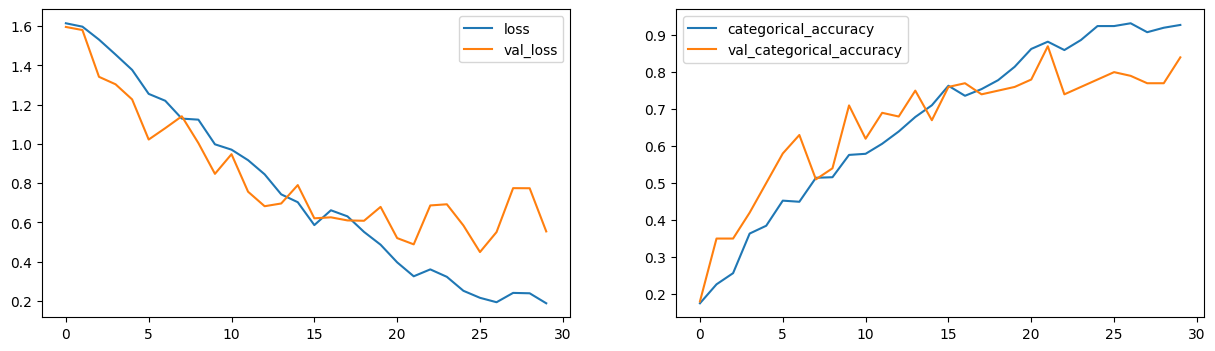

Execution time (secs): 1408.802429676056 Memory usage(MB) 632.346
Best stats:
       loss  categorical_accuracy  val_loss  val_categorical_accuracy     lr
25  0.21489              0.924585   0.44819                       0.8  0.001


In [ ]:
st = time.time()
hist,model = try_cnn3d_only(batch_size= 30, num_epochs=30, num_gesture_frames= 30,
                                   image_size= 64, num_channels=1, batch_normalize=False,
                                   learning_rate= 0.001, dropout= 0.25, dense_neurons=128)
df_train = pd.DataFrame(hist.history)
df_best = df_train[df_train['val_loss'] == df_train['val_loss'].min()]
et = time.time()
elapsed_time = et - st
mbs = get_model_memory_usage(30, model)
print("Execution time (secs):", elapsed_time, "Memory usage(MB)", mbs)
print("Best stats:")
print(df_best)

**Let's create a generic function for CNN_LTSM to experiment with different model, given with different input paramters**

In [ ]:
def try_cnn_lstm(batch_size, num_epochs, num_gesture_frames, image_size, num_channels, batch_normalize, learning_rate, dropout, dense_neurons, rnn_cells) :
  model = Sequential()

  model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                            input_shape=(num_gesture_frames, image_size, image_size, num_channels)))
  model.add(TimeDistributed(MaxPooling2D((2, 2))))

  model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
  model.add(TimeDistributed(MaxPooling2D((2, 2))))

  model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
  model.add(TimeDistributed(MaxPooling2D((2, 2))))

  model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
  model.add(TimeDistributed(MaxPooling2D((2, 2))))

  model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
  model.add(TimeDistributed(MaxPooling2D((2, 2))))

  model.add(TimeDistributed(Flatten()))

  model.add(LSTM(rnn_cells))

  model.add(Dense(dense_neurons, activation='relu'))
  model.add(Dropout(dropout))

  model.add(Dense(num_gestures, activation='softmax'))

  print('Total params: {:,}'.format(model.count_params()))

  return build_model("cnn_lstm", model, batch_size, num_epochs, num_gesture_frames, image_size, num_channels, learning_rate), model

### *`MODEL-CNN2D_LTSM 1`*

Total params: 680,357


<ipython-input-9-9dc86df5bb8a>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(source_path + '/' + gesture_info[0] +'/'+imgs[item]).astype(np.float32)


Epoch 1/20
23/23 [==============================] - ETA: 0s - loss: 1.6155 - categorical_accuracy: 0.1900
Epoch 1: val_loss improved from inf to 1.60236, saving model to cnn_lstm_2023-08-0211_36_55.184463/model-00001-1.61551-0.19005-1.60236-0.25000.h5
23/23 [==============================] - 77s 3s/step - loss: 1.6155 - categorical_accuracy: 0.1900 - val_loss: 1.6024 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 2/20
23/23 [==============================] - ETA: 0s - loss: 1.6055 - categorical_accuracy: 0.2383
Epoch 2: val_loss improved from 1.60236 to 1.58200, saving model to cnn_lstm_2023-08-0211_36_55.184463/model-00002-1.60550-0.23831-1.58200-0.20000.h5
23/23 [==============================] - 67s 3s/step - loss: 1.6055 - categorical_accuracy: 0.2383 - val_loss: 1.5820 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/20
23/23 [==============================] - ETA: 0s - loss: 1.5360 - categorical_accuracy: 0.3032
Epoch 3: val_loss improved from 1.58200 to 1.38215, sa

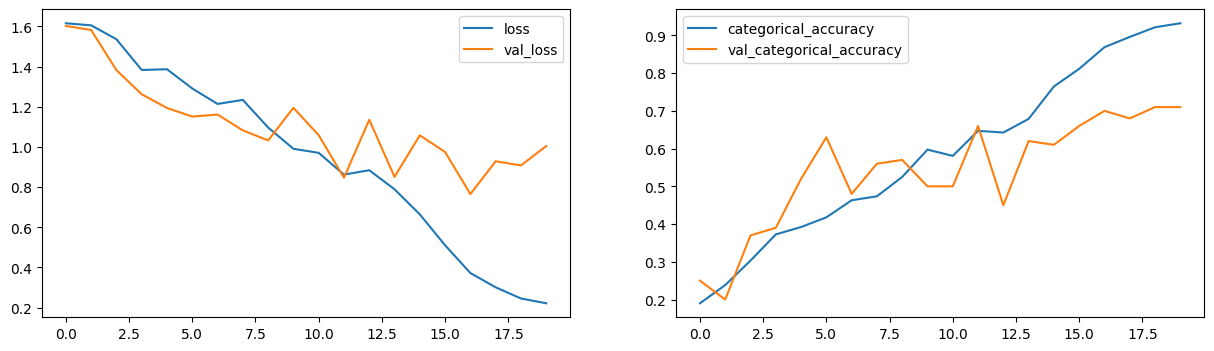

Execution time (secs): 3139.6813352108 Memory usage(MB) 551.07
Best stats:
        loss  categorical_accuracy  val_loss  val_categorical_accuracy      lr
16  0.372279              0.868778  0.765292                       0.7  0.0002


In [ ]:
st = time.time()
hist,model = try_cnn_lstm(batch_size=30, num_epochs=20, num_gesture_frames= 30,
                                      image_size=64, num_channels=3, batch_normalize=False,
                                      learning_rate=.001, dropout=0.25, dense_neurons=128, rnn_cells=64)
df_train = pd.DataFrame(hist.history)
df_best = df_train[df_train['val_loss'] == df_train['val_loss'].min()]
et = time.time()
elapsed_time = et - st
mbs = get_model_memory_usage(30, model)
print("Execution time (secs):", elapsed_time, "Memory usage(MB)", mbs)
print("Best stats:")
print(df_best)

### *`MODEL_CNN2D_LTSM 2`*

Total params: 2,572,677
Epoch 1/25
17/17 [==============================] - ETA: 0s - loss: 1.6246 - categorical_accuracy: 0.1931
Epoch 1: val_loss improved from inf to 1.57244, saving model to cnn_lstm_2023-08-0212_02_02.806850/model-00001-1.62464-0.19306-1.57244-0.26000.h5
17/17 [==============================] - 71s 4s/step - loss: 1.6246 - categorical_accuracy: 0.1931 - val_loss: 1.5724 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 2/25
17/17 [==============================] - ETA: 0s - loss: 1.5498 - categorical_accuracy: 0.2821
Epoch 2: val_loss improved from 1.57244 to 1.34527, saving model to cnn_lstm_2023-08-0212_02_02.806850/model-00002-1.54984-0.28205-1.34527-0.46000.h5
17/17 [==============================] - 64s 4s/step - loss: 1.5498 - categorical_accuracy: 0.2821 - val_loss: 1.3453 - val_categorical_accuracy: 0.4600 - lr: 0.0010
Epoch 3/25
17/17 [==============================] - ETA: 0s - loss: 1.3450 - categorical_accuracy: 0.4042
Epoch 3: val_loss improved fro

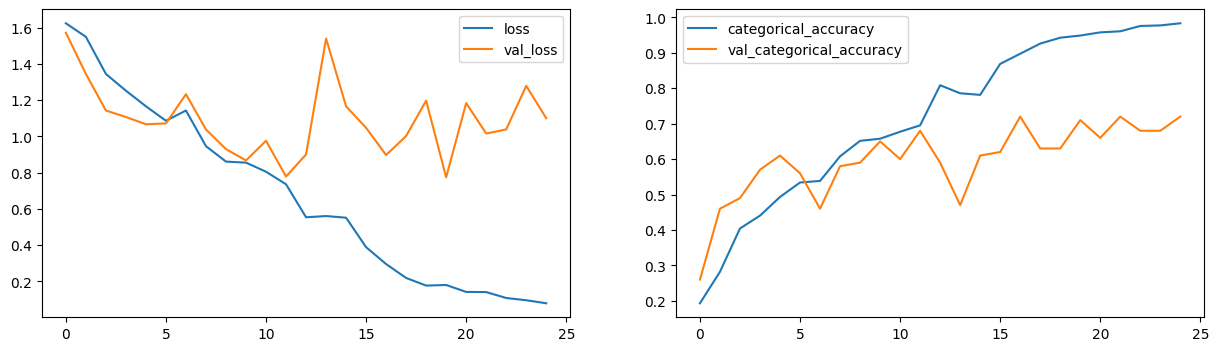

Execution time (secs): 4647.851849317551 Memory usage(MB) 2934.873
Best stats:
        loss  categorical_accuracy  val_loss  val_categorical_accuracy      lr
19  0.180251              0.948718  0.774845                      0.71  0.0002


In [ ]:
st = time.time()
hist,model = try_cnn_lstm(batch_size=40, num_epochs=25, num_gesture_frames=30,
                                      image_size=128 ,num_channels=1, batch_normalize=False,
                                      learning_rate= 0.001, dropout=0.25, dense_neurons=128, rnn_cells=128)
df_train = pd.DataFrame(hist.history)
df_best = df_train[df_train['val_loss'] == df_train['val_loss'].min()]
et = time.time()
elapsed_time = et - st
mbs = get_model_memory_usage(40, model)
print("Execution time (secs):", elapsed_time, "Memory usage(MB)", mbs)
print("Best stats:")
print(df_best)

### *`MODEL-CNN2D_LTSM 3`*

Total params: 4,916,869
Epoch 1/20
27/27 [==============================] - ETA: 0s - loss: 1.6146 - categorical_accuracy: 0.1900
Epoch 1: val_loss improved from inf to 1.58642, saving model to cnn_lstm_2023-08-0212_26_37.376940/model-00001-1.61463-0.19005-1.58642-0.24000.h5
27/27 [==============================] - 72s 2s/step - loss: 1.6146 - categorical_accuracy: 0.1900 - val_loss: 1.5864 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 2/20
27/27 [==============================] - ETA: 0s - loss: 1.5130 - categorical_accuracy: 0.3002
Epoch 2: val_loss improved from 1.58642 to 1.37790, saving model to cnn_lstm_2023-08-0212_26_37.376940/model-00002-1.51303-0.30015-1.37790-0.28000.h5
27/27 [==============================] - 53s 2s/step - loss: 1.5130 - categorical_accuracy: 0.3002 - val_loss: 1.3779 - val_categorical_accuracy: 0.2800 - lr: 0.0010
Epoch 3/20
27/27 [==============================] - ETA: 0s - loss: 1.3409 - categorical_accuracy: 0.4027
Epoch 3: val_loss improved fro

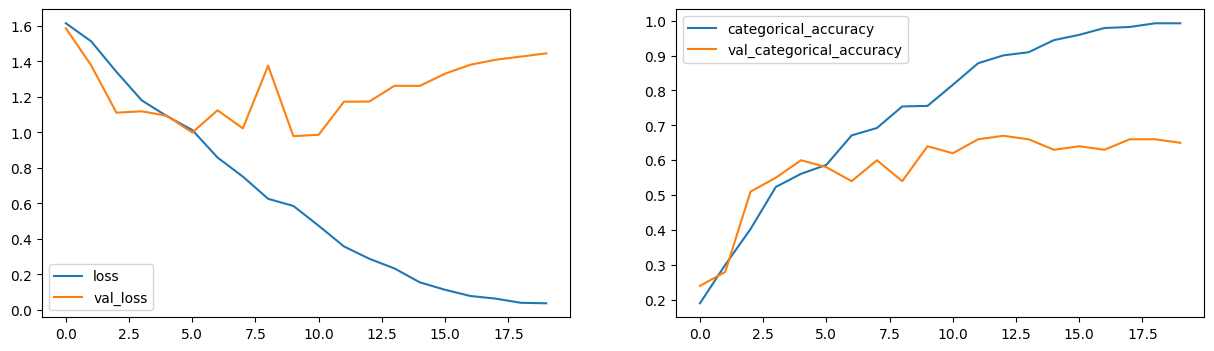

Execution time (secs): 4647.851849317551 Memory usage(MB) 2177.918
Best stats:
       loss  categorical_accuracy  val_loss  val_categorical_accuracy     lr
9  0.585273              0.755656  0.978482                      0.64  0.001


In [ ]:
st = time.time()
hist,model = try_cnn_lstm(batch_size=25, num_epochs=20, num_gesture_frames=30,
                                      image_size=140, num_channels=1, batch_normalize=False,
                                      learning_rate=0.001, dropout= 0.25, dense_neurons= 256, rnn_cells= 256)
df_train = pd.DataFrame(hist.history)
df_best = df_train[df_train['val_loss'] == df_train['val_loss'].min()]
et = time.time()
elapsed_time = et - st
mbs = get_model_memory_usage(25, model)
print("Execution time (secs):", elapsed_time, "Memory usage(MB)", mbs)
print("Best stats:")
print(df_best)


### *`MODEL-CNN2D_LTSM 4`*

Total params: 1,838,501


<ipython-input-9-9dc86df5bb8a>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(source_path + '/' + gesture_info[0] +'/'+imgs[item]).astype(np.float32)


Epoch 1/25
23/23 [==============================] - ETA: 0s - loss: 1.6190 - categorical_accuracy: 0.2127
Epoch 1: val_loss improved from inf to 1.59453, saving model to cnn_lstm_2023-08-0806_23_40.550711/model-00001-1.61900-0.21267-1.59453-0.24000.h5
23/23 [==============================] - 72s 3s/step - loss: 1.6190 - categorical_accuracy: 0.2127 - val_loss: 1.5945 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 2/25
23/23 [==============================] - ETA: 0s - loss: 1.6028 - categorical_accuracy: 0.2097
Epoch 2: val_loss improved from 1.59453 to 1.53820, saving model to cnn_lstm_2023-08-0806_23_40.550711/model-00002-1.60282-0.20965-1.53820-0.28000.h5
23/23 [==============================] - 64s 3s/step - loss: 1.6028 - categorical_accuracy: 0.2097 - val_loss: 1.5382 - val_categorical_accuracy: 0.2800 - lr: 0.0010
Epoch 3/25
23/23 [==============================] - ETA: 0s - loss: 1.5522 - categorical_accuracy: 0.2790
Epoch 3: val_loss did not improve from 1.53820
23/23 [

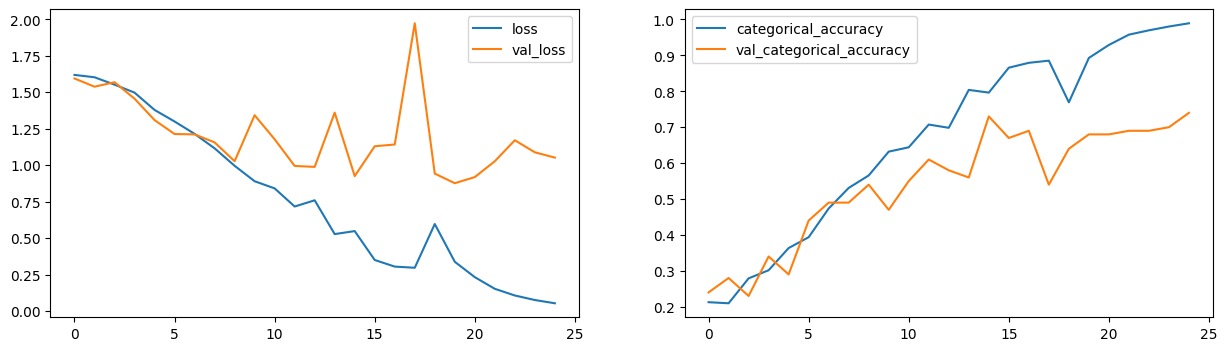

Execution time (secs): 1619.7738571166992 Memory usage(MB) 555.598
Best stats:
        loss  categorical_accuracy  val_loss  val_categorical_accuracy      lr
19  0.337761              0.892911  0.876419                      0.68  0.0002


In [ ]:
st = time.time()
hist,model = try_cnn_lstm(batch_size= 30, num_epochs= 25, num_gesture_frames= 30,
                                      image_size= 64, num_channels= 3, batch_normalize=False,
                                      learning_rate= 0.001, dropout= 0.25, dense_neurons= 512, rnn_cells= 256)
df_train = pd.DataFrame(hist.history)
df_best = df_train[df_train['val_loss'] == df_train['val_loss'].min()]
et = time.time()
elapsed_time = et - st
mbs = get_model_memory_usage(30, model)
print("Execution time (secs):", elapsed_time, "Memory usage(MB)", mbs)
print("Best stats:")
print(df_best)


### *`MODEL-CNN2D_LTSM 5`*

Total params: 680,357


<ipython-input-9-9dc86df5bb8a>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(source_path + '/' + gesture_info[0] +'/'+imgs[item]).astype(np.float32)


Epoch 1/30
17/17 [==============================] - ETA: 0s - loss: 1.6079 - categorical_accuracy: 0.1900
Epoch 1: val_loss improved from inf to 1.56112, saving model to cnn_lstm_2023-08-0807_01_25.083749/model-00001-1.60793-0.19005-1.56112-0.28000.h5
17/17 [==============================] - 67s 4s/step - loss: 1.6079 - categorical_accuracy: 0.1900 - val_loss: 1.5611 - val_categorical_accuracy: 0.2800 - lr: 0.0010
Epoch 2/30
17/17 [==============================] - ETA: 0s - loss: 1.5429 - categorical_accuracy: 0.2624
Epoch 2: val_loss improved from 1.56112 to 1.40869, saving model to cnn_lstm_2023-08-0807_01_25.083749/model-00002-1.54285-0.26244-1.40869-0.44000.h5
17/17 [==============================] - 61s 4s/step - loss: 1.5429 - categorical_accuracy: 0.2624 - val_loss: 1.4087 - val_categorical_accuracy: 0.4400 - lr: 0.0010
Epoch 3/30
17/17 [==============================] - ETA: 0s - loss: 1.4668 - categorical_accuracy: 0.3499
Epoch 3: val_loss did not improve from 1.40869
17/17 [

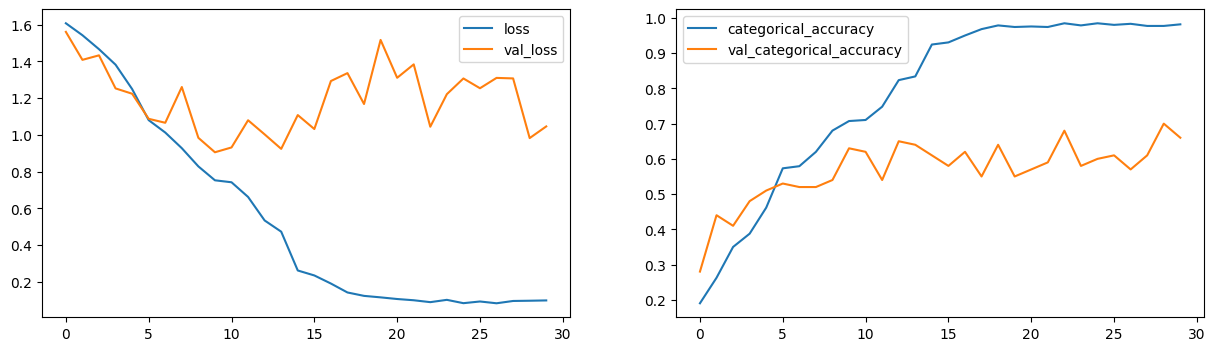

Execution time (secs): 1854.6155714988708 Memory usage(MB) 733.895
Best stats:
       loss  categorical_accuracy  val_loss  val_categorical_accuracy     lr
9  0.752631              0.707391  0.905341                      0.63  0.001


In [ ]:
st = time.time()
hist,model = try_cnn_lstm(batch_size= 40, num_epochs= 30, num_gesture_frames= 30,
                                      image_size= 64, num_channels= 3, batch_normalize=False,
                                      learning_rate= 0.001, dropout= 0.25, dense_neurons= 128, rnn_cells= 64)
df_train = pd.DataFrame(hist.history)
df_best = df_train[df_train['val_loss'] == df_train['val_loss'].min()]
et = time.time()
elapsed_time = et - st
mbs = get_model_memory_usage(40, model)
print("Execution time (secs):", elapsed_time, "Memory usage(MB)", mbs)
print("Best stats:")
print(df_best)

### *`MODEL-CNN2D_LTSM 6`*

Total params: 1,000,101


<ipython-input-9-9dc86df5bb8a>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(source_path + '/' + gesture_info[0] +'/'+imgs[item]).astype(np.float32)


Epoch 1/30
23/23 [==============================] - ETA: 0s - loss: 1.6108 - categorical_accuracy: 0.2247
Epoch 1: val_loss improved from inf to 1.59654, saving model to cnn_lstm_2023-08-0807_36_30.823194/model-00001-1.61076-0.22474-1.59654-0.25000.h5
23/23 [==============================] - 70s 3s/step - loss: 1.6108 - categorical_accuracy: 0.2247 - val_loss: 1.5965 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 2/30
23/23 [==============================] - ETA: 0s - loss: 1.5934 - categorical_accuracy: 0.2534
Epoch 2: val_loss improved from 1.59654 to 1.51805, saving model to cnn_lstm_2023-08-0807_36_30.823194/model-00002-1.59338-0.25339-1.51805-0.31000.h5
23/23 [==============================] - 62s 3s/step - loss: 1.5934 - categorical_accuracy: 0.2534 - val_loss: 1.5180 - val_categorical_accuracy: 0.3100 - lr: 0.0010
Epoch 3/30
23/23 [==============================] - ETA: 0s - loss: 1.4941 - categorical_accuracy: 0.2941
Epoch 3: val_loss improved from 1.51805 to 1.25266, sa

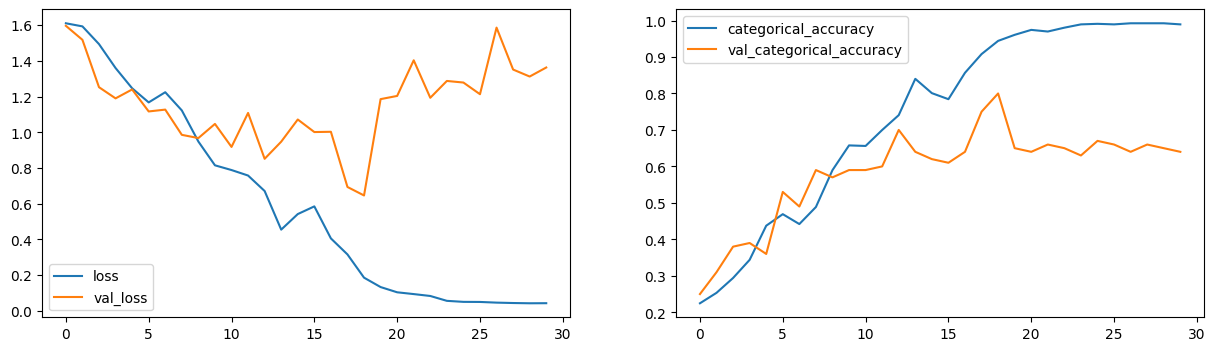

Execution time (secs): 1828.248945236206 Memory usage(MB) 552.297
Best stats:
        loss  categorical_accuracy  val_loss  val_categorical_accuracy      lr
18  0.185548              0.944193  0.646062                       0.8  0.0002


In [ ]:
st = time.time()
hist,model = try_cnn_lstm(batch_size= 30, num_epochs= 30, num_gesture_frames= 30,
                                      image_size= 64, num_channels= 3, batch_normalize=False,
                                      learning_rate= 0.001, dropout= 0.25, dense_neurons= 128, rnn_cells= 128)
df_train = pd.DataFrame(hist.history)
df_best = df_train[df_train['val_loss'] == df_train['val_loss'].min()]
et = time.time()
elapsed_time = et - st
mbs = get_model_memory_usage(30, model)
print("Execution time (secs):", elapsed_time, "Memory usage(MB)", mbs)
print("Best stats:")
print(df_best)

Let's try changing a bit of architecture of CNN2D_LTSM and train a model

In [ ]:
def try_cnn_lstm_2(batch_size, num_epochs, num_gesture_frames, image_size, num_channels, batch_normalize, learning_rate, dropout, dense_neurons, rnn_cells) :
  model = Sequential()
  model.add(TimeDistributed(Conv2D(8, (3,3), padding='same', activation='relu'), input_shape=(num_gesture_frames, image_size, image_size, num_channels)))
  model.add(BatchNormalization())

  model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu')))
  model.add(BatchNormalization())

  model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
  model.add(BatchNormalization())

  model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
  model.add(BatchNormalization())

  model.add(ConvLSTM2D(rnn_cells, kernel_size = 3, return_sequences=False))
  model.add(BatchNormalization())

  model.add(TimeDistributed(Dense(64, activation='relu')))
  model.add(BatchNormalization())

  model.add(GlobalAveragePooling2D())

  model.add(Dense(dense_neurons, activation='relu'))
  model.add(Dropout(dropout))

  model.add(Dense(num_gestures, activation='softmax'))

  print('Total params: {:,}'.format(model.count_params()))

  return build_model("cnn_lstm_2", model, batch_size, num_epochs, num_gesture_frames, image_size, num_channels, learning_rate), model

### *`MODEL-CNN2D_LTSM 7`*

Total params: 51,125


<ipython-input-9-9dc86df5bb8a>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(source_path + '/' + gesture_info[0] +'/'+imgs[item]).astype(np.float32)


Epoch 1/40
23/23 [==============================] - ETA: 0s - loss: 1.5047 - categorical_accuracy: 0.3454
Epoch 1: val_loss improved from inf to 1.61369, saving model to cnn_lstm_2_2023-08-0811_03_40.365144/model-00001-1.50472-0.34540-1.61369-0.23000.h5
23/23 [==============================] - 57s 2s/step - loss: 1.5047 - categorical_accuracy: 0.3454 - val_loss: 1.6137 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/40
23/23 [==============================] - ETA: 0s - loss: 1.2244 - categorical_accuracy: 0.5430
Epoch 2: val_loss did not improve from 1.61369
23/23 [==============================] - 35s 2s/step - loss: 1.2244 - categorical_accuracy: 0.5430 - val_loss: 1.6532 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 3/40
23/23 [==============================] - ETA: 0s - loss: 1.0363 - categorical_accuracy: 0.5988
Epoch 3: val_loss did not improve from 1.61369
23/23 [==============================] - 34s 2s/step - loss: 1.0363 - categorical_accuracy: 0.5988 - val_los

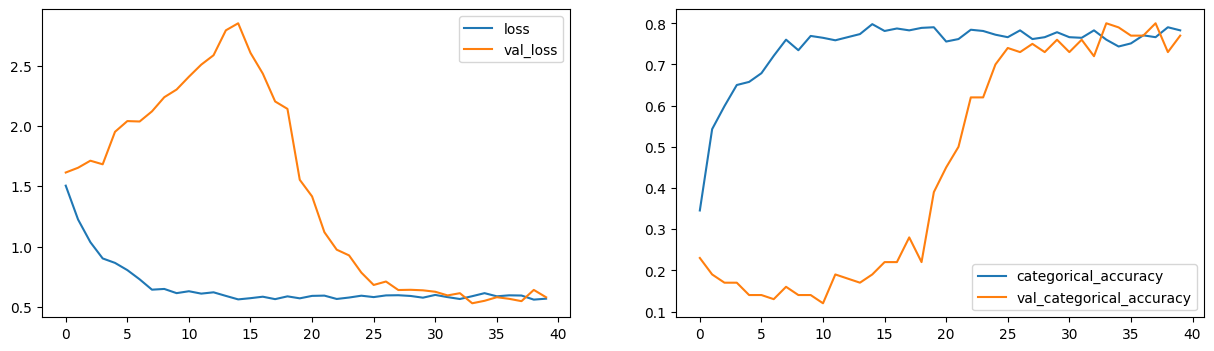

Execution time (secs): 1411.7694647312164 Memory usage(MB) 4184.756
Best stats:
        loss  categorical_accuracy  val_loss  val_categorical_accuracy  \
33  0.588716              0.760181  0.530007                       0.8   

          lr  
33  0.000008  


In [ ]:
st = time.time()
hist,model = try_cnn_lstm_2(batch_size= 30, num_epochs= 40, num_gesture_frames= 10,
                            image_size= 120, num_channels= 3, batch_normalize=False,
                                      learning_rate= 0.001, dropout= 0.25, dense_neurons= 64, rnn_cells= 8)
df_train = pd.DataFrame(hist.history)
df_best = df_train[df_train['val_loss'] == df_train['val_loss'].min()]
et = time.time()
elapsed_time = et - st
mbs = get_model_memory_usage(30, model)
print("Execution time (secs):", elapsed_time, "Memory usage(MB)", mbs)
print("Best stats:")
print(df_best)

**Let's create a generic function for Timedistributed CNN2D_GRU to experiment with different model, given with different input paramters**

In [ ]:
def try_cnn2d_gru(batch_size, num_epochs, num_gesture_frames, image_size, num_channels, batch_normalize, learning_rate, dropout, dense_neurons, rnn_cells) :
  model = Sequential()

  model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                            input_shape=(num_gesture_frames, image_size, image_size, num_channels)))
  model.add(TimeDistributed(MaxPooling2D((2, 2))))

  model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
  model.add(TimeDistributed(MaxPooling2D((2, 2))))

  model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
  model.add(TimeDistributed(MaxPooling2D((2, 2))))

  model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
  model.add(TimeDistributed(MaxPooling2D((2, 2))))

  model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
  model.add(TimeDistributed(MaxPooling2D((2, 2))))

  model.add(TimeDistributed(Flatten()))

  model.add(GRU(rnn_cells))

  model.add(Dense(dense_neurons, activation='relu'))
  model.add(Dropout(dropout))

  model.add(Dense(num_gestures, activation='softmax'))

  print('Total params: {:,}'.format(model.count_params()))

  return build_model("cnn_gru", model, batch_size, num_epochs, num_gesture_frames, image_size, num_channels, learning_rate), model

### *`MODEL-CNN2D_GRU 1`*

Total params: 904,357


<ipython-input-9-9dc86df5bb8a>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(source_path + '/' + gesture_info[0] +'/'+imgs[item]).astype(np.float32)


Epoch 1/30
23/23 [==============================] - ETA: 0s - loss: 1.6163 - categorical_accuracy: 0.2081
Epoch 1: val_loss improved from inf to 1.60227, saving model to cnn_gru_2023-08-0814_35_28.627643/model-00001-1.61631-0.20814-1.60227-0.18000.h5
23/23 [==============================] - 96s 3s/step - loss: 1.6163 - categorical_accuracy: 0.2081 - val_loss: 1.6023 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 2/30
23/23 [==============================] - ETA: 0s - loss: 1.5819 - categorical_accuracy: 0.2323
Epoch 2: val_loss improved from 1.60227 to 1.54278, saving model to cnn_gru_2023-08-0814_35_28.627643/model-00002-1.58195-0.23228-1.54278-0.24000.h5
23/23 [==============================] - 75s 3s/step - loss: 1.5819 - categorical_accuracy: 0.2323 - val_loss: 1.5428 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 3/30
23/23 [==============================] - ETA: 0s - loss: 1.4421 - categorical_accuracy: 0.3439
Epoch 3: val_loss improved from 1.54278 to 1.37672, savi

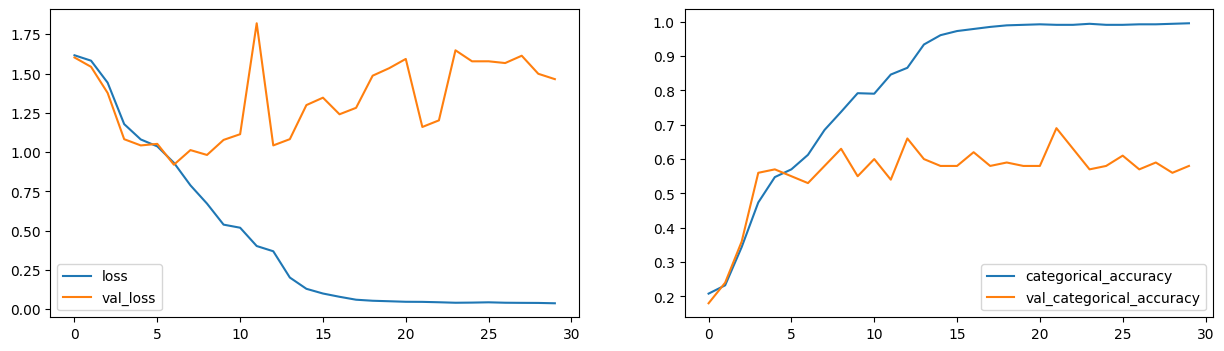

Execution time (secs): 2199.0467529296875 Memory usage(MB) 552.02
Best stats:
       loss  categorical_accuracy  val_loss  val_categorical_accuracy     lr
6  0.932555              0.612368  0.919931                      0.53  0.001


In [ ]:
st = time.time()
hist,model = try_cnn2d_gru(batch_size= 30, num_epochs= 30, num_gesture_frames= 30,
                                      image_size= 64, num_channels= 3, batch_normalize=False,
                                      learning_rate= 0.001, dropout= 0.25, dense_neurons= 512, rnn_cells= 128)
df_train = pd.DataFrame(hist.history)
df_best = df_train[df_train['val_loss'] == df_train['val_loss'].min()]
et = time.time()
elapsed_time = et - st
mbs = get_model_memory_usage(30, model)
print("Execution time (secs):", elapsed_time, "Memory usage(MB)", mbs)
print("Best stats:")
print(df_best)

### *`MODEL-CNN2D_GRU 2`*

Total params: 1,444,261


<ipython-input-9-9dc86df5bb8a>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(source_path + '/' + gesture_info[0] +'/'+imgs[item]).astype(np.float32)


Epoch 1/20
23/23 [==============================] - ETA: 0s - loss: 1.6130 - categorical_accuracy: 0.2021
Epoch 1: val_loss improved from inf to 1.58230, saving model to cnn_gru_2023-08-0815_12_49.378314/model-00001-1.61296-0.20211-1.58230-0.24000.h5
23/23 [==============================] - 82s 3s/step - loss: 1.6130 - categorical_accuracy: 0.2021 - val_loss: 1.5823 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 2/20
23/23 [==============================] - ETA: 0s - loss: 1.6011 - categorical_accuracy: 0.2021
Epoch 2: val_loss did not improve from 1.58230
23/23 [==============================] - 74s 3s/step - loss: 1.6011 - categorical_accuracy: 0.2021 - val_loss: 1.6110 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 3/20
23/23 [==============================] - ETA: 0s - loss: 1.5734 - categorical_accuracy: 0.2609
Epoch 3: val_loss improved from 1.58230 to 1.48626, saving model to cnn_gru_2023-08-0815_12_49.378314/model-00003-1.57344-0.26094-1.48626-0.32000.h5
23/23 [==

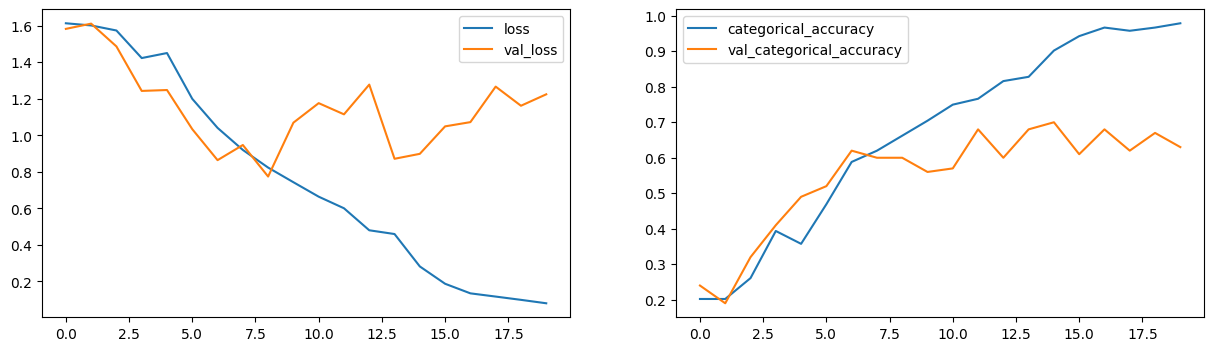

Execution time (secs): 1466.5755062103271 Memory usage(MB) 554.035
Best stats:
       loss  categorical_accuracy  val_loss  val_categorical_accuracy     lr
8  0.823208              0.662142  0.774209                       0.6  0.001


In [ ]:
st = time.time()
hist,model = try_cnn2d_gru(batch_size= 30, num_epochs= 20, num_gesture_frames=30,
                                      image_size= 64, num_channels=3, batch_normalize=False,
                                      learning_rate= 0.001, dropout = 0.25, dense_neurons= 256, rnn_cells=256)
df_train = pd.DataFrame(hist.history)
df_best = df_train[df_train['val_loss'] == df_train['val_loss'].min()]
et = time.time()
elapsed_time = et - st
mbs = get_model_memory_usage(30, model)
print("Execution time (secs):", elapsed_time, "Memory usage(MB)", mbs)
print("Best stats:")
print(df_best)

## *`Insights`*

**Based on our observations, let's analyze the best model:**

- *Model 2 (CNN3D):* Among the CNN3D models, Model 2
stands out with a validation accuracy of 83%, which is the
highest among CNN3D models. It also has a reasonable
number of parameters.
- *Model 2 (CNN2D_LTSM):* This model has a relatively high
training accuracy (94.87%) and a validation accuracy of
71%. The number of parameters is moderate.
- *Model 6 (CNN2D_LTSM):* Model 6 has a high training
accuracy (94.42%) and the highest validation accuracy of
80%. The number of parameters is relatively moderate.
- *Model 4 (CNN2D+LSTM):* This model shows a good
balance between training and validation accuracies with
reasonable parameters.
- Both models in the CNN2D_GRU architecture exhibit overfitting, with the validation accuracies lagging behind the training accuracies.



## *`Conclusion and Final Model`*

**As per my analysis, I have considered below two model
as best fit :**

*Model 2:*
- Architecture: CNN3D
- Total params: 2,218,501
- Training Loss: 0.454797, Training Accuracy:83.56%
- Validation Loss: 0.399113, Validation Accuracy:83%
- Learning Rate: 0.001

*Model 4:*
- Architecture: CNN3D
- Total params: 357,541
- Training Loss: 0.21489, Training Accuracy: 92.46%
- Validation Loss: 0.44819, Validation Accuracy:80%
- Learning Rate: 0.001


Now, upon reevaluation, considering our preference for minimizing
parameters, minimizing overfitting, and having the least validation
loss, Model 2 from the CNN3D architecture might indeed be the
better fit.

**Reasons for Choosing Model 2:**
- *Validation Accuracy and Loss:* Model 2 achieves a higher
validation accuracy (83%) and a slightly lower validation
loss (0.399113) compared to Model 4.
- *Overfitting:* While both models demonstrate minimal
overfitting, Model 2's training and validation accuracies
are closer, indicating a slightly better generalization.
- *Parameters:* While Model 4 has fewer parameters, Model
2's parameter count (2,218,501) is still reasonable and
might not significantly impact inference times